## Modelos de Aprendizaje Supervizado : REGRESIÓN LOGISTICA Y RANDOM FOREST

In [8]:
# ==========================================
# 1. IMPORTACIÓN DE LIBRERÍAS Y DATOS
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)

In [9]:
# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("--- PASO 1: CARGA DE DATOS ---")

--- PASO 1: CARGA DE DATOS ---


In [10]:
# Cargar el dataset
file_path = 'Portafolio_Negocios.csv'
df = pd.read_csv(file_path, sep=';', encoding='latin1') # Probamos delimitador ;
print(f"Dimensiones iniciales: {df.shape}")
print(df.info())

Dimensiones iniciales: (59258, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59258 entries, 0 to 59257
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CODMES               59258 non-null  int64 
 1   ID                   59258 non-null  int64 
 2   DEFAULT              59258 non-null  int64 
 3   DEUDA_RCC            59258 non-null  object
 4   ATRASO_12M           59258 non-null  int64 
 5   CLASIFSBS            59258 non-null  int64 
 6   VARPASIVO_6_12       59258 non-null  object
 7   FLUJO_TRANSACCIONAL  59258 non-null  object
dtypes: int64(5), object(3)
memory usage: 3.6+ MB
None


In [11]:
df.head()

,CODMES,ID,DEFAULT,DEUDA_RCC,ATRASO_12M,CLASIFSBS,VARPASIVO_6_12,FLUJO_TRANSACCIONAL
0,201801,415536,0,439.180.185,0,0,1.212.356.158,55.803.591
1,201803,415536,0,439.159.965,0,0,1.145.527.647,25.444.246
2,201802,415536,0,439247.91,0,0,119.320.743,41.087.876
3,201805,415536,0,439342.86,0,0,999.670.555,93.758.626
4,201804,415536,0,439185.03,4,0,1.072.088.311,27.453.317


In [12]:
# ==========================================
# 2. LIMPIEZA INICIAL (CRÍTICO PARA ESTE DATASET)
# ==========================================
print("\n--- PASO 2: LIMPIEZA DE FORMATOS NUMÉRICOS MIXTOS ---")


--- PASO 2: LIMPIEZA DE FORMATOS NUMÉRICOS MIXTOS ---


In [13]:
# Las columnas DEUDA_RCC, VARPASIVO_6_12, FLUJO_TRANSACCIONAL vienen como 'object'
# porque mezclan formatos (ej: '439.180.185' y '439247.91').

def limpiar_moneda(x):
    if isinstance(x, str):
        # Si tiene más de un punto, asumimos que son separadores de miles -> quitamos todos los puntos
        if x.count('.') > 1:
            return float(x.replace('.', ''))
        # Si tiene un solo punto, asumimos que es decimal (ej: 439247.91 o 1.01)
        # NOTA: Esto es una heurística basada en la visualización de tus datos.
        elif x.count('.') == 1:
            return float(x)
        # Si no tiene puntos, convertir directo
        else:
            return float(x)
    return x

cols_to_fix = ['DEUDA_RCC', 'VARPASIVO_6_12', 'FLUJO_TRANSACCIONAL']

for col in cols_to_fix:
    df[col] = df[col].apply(limpiar_moneda)

print("Datos corregidos (ejemplo):")
print(df[cols_to_fix].head())

Datos corregidos (ejemplo):
     DEUDA_RCC  VARPASIVO_6_12  FLUJO_TRANSACCIONAL
0 439180185.00   1212356158.00          55803591.00
1 439159965.00   1145527647.00          25444246.00
2    439247.91    119320743.00          41087876.00
3    439342.86    999670555.00          93758626.00
4    439185.03   1072088311.00          27453317.00


In [14]:
# ==========================================
# 3. EXPLORACIÓN Y DIAGNÓSTICO (EDA)
# ==========================================
print("\n--- PASO 3: EDA ---")


--- PASO 3: EDA ---


In [15]:
# Estadísticas descriptivas
print(df.describe())

         CODMES          ID  DEFAULT     DEUDA_RCC  ATRASO_12M  CLASIFSBS  \
count  59258.00    59258.00 59258.00      59258.00    59258.00   59258.00   
mean  201806.49 13602852.17     0.04 1023389466.42       16.06       0.09   
std        3.45  8444967.07     0.21 1870035039.81      142.77       0.38   
min   201801.00   415536.00     0.00          0.00        0.00       0.00   
25%   201803.00  7248226.00     0.00    1486328.50        0.00       0.00   
50%   201806.00 12455030.00     0.00   10242689.46        0.00       0.00   
75%   201809.00 18328004.00     0.00 1307082255.00        0.00       0.00   
max   201812.00 44626106.00     1.00 9997769055.00     2736.00       4.00   

       VARPASIVO_6_12  FLUJO_TRANSACCIONAL  
count        59258.00             59258.00  
mean     925483756.53         178084181.42  
std      476068066.12         603503451.32  
min              0.01                 0.02  
25%      730683526.75          31096651.75  
50%      981469163.00          64205

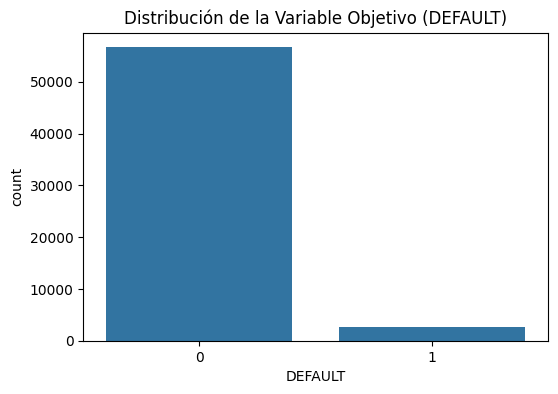

Balance de clases:
DEFAULT
0   0.96
1   0.04
Name: proportion, dtype: float64


In [16]:
# Distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.countplot(x='DEFAULT', data=df)
plt.title('Distribución de la Variable Objetivo (DEFAULT)')
plt.show()
print("Balance de clases:")
print(df['DEFAULT'].value_counts(normalize=True))

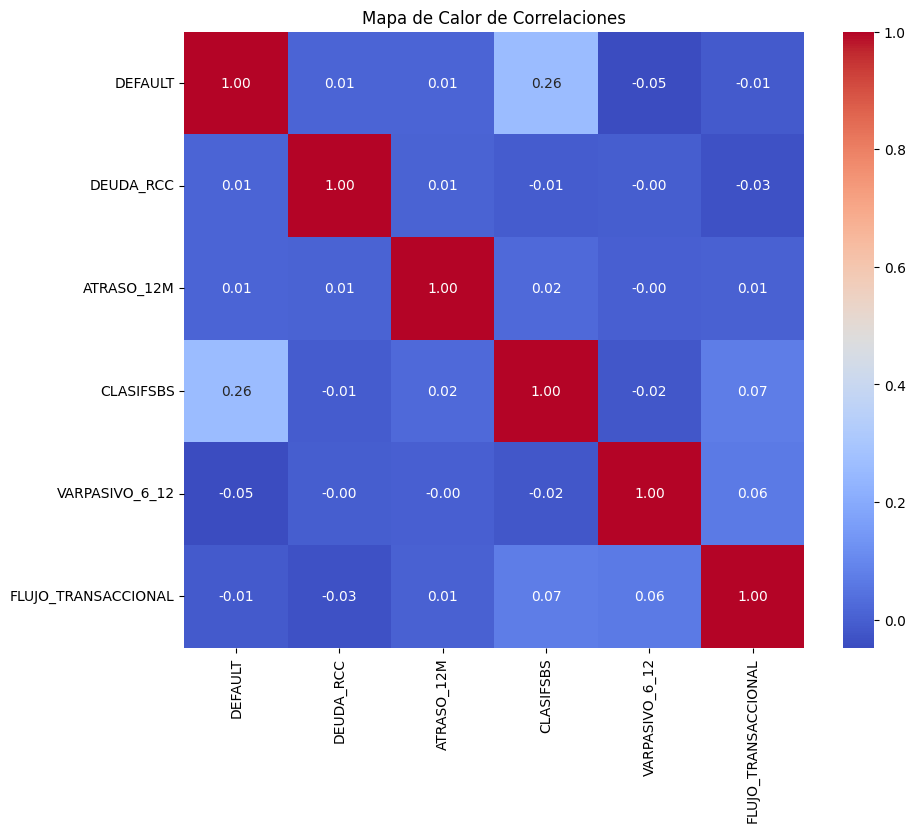

In [17]:
# Matriz de Correlación (Variables numéricas)
plt.figure(figsize=(10,8))
cols_corr = ['DEFAULT', 'DEUDA_RCC', 'ATRASO_12M', 'CLASIFSBS', 'VARPASIVO_6_12', 'FLUJO_TRANSACCIONAL']
sns.heatmap(df[cols_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlaciones')
plt.show()

In [18]:
# ==========================================
# 4. TRATAMIENTO DE DATOS (Outliers y Missing)
# ==========================================
print("\n--- PASO 4: PREPARACIÓN DE DATOS ---")


--- PASO 4: PREPARACIÓN DE DATOS ---


In [19]:
# 4.1 Valores Faltantes
# Verificamos nulos
missings = df.isnull().sum()
print("Valores nulos por columna:\n", missings[missings > 0])

Valores nulos por columna:
 Series([], dtype: int64)


In [20]:
# Imputación (Si hubiera nulos, usamos mediana para ser robustos a outliers)
imputer = SimpleImputer(strategy='median')
df[cols_corr[1:]] = imputer.fit_transform(df[cols_corr[1:]])

In [21]:
# 4.2 Tratamiento de Outliers (Winsorización / Recorte al 1.5*IQR o Percentiles)
# Usaremos recorte de percentiles (1% y 99%) para evitar que valores extremos dañen la regresión
def winsorize_series(s, lower=0.01, upper=0.99):
    low_val = s.quantile(lower)
    up_val = s.quantile(upper)
    return s.clip(lower=low_val, upper=up_val)
cols_numericas = ['DEUDA_RCC', 'VARPASIVO_6_12', 'FLUJO_TRANSACCIONAL', 'ATRASO_12M']
for col in cols_numericas:
    df[col] = winsorize_series(df[col])

In [22]:
# 4.3 Variables Cualitativas / Categóricas
# 'CLASIFSBS' aunque es numérica, representa categorías ordinales (0 es mejor que 4).
# La dejaremos numérica para mantener el orden.
# 'CODMES' y 'ID' no son predictoras, las eliminamos para el modelo.

X = df.drop(columns=['DEFAULT', 'ID', 'CODMES']) # Variables Independientes
y = df['DEFAULT']                                # Variable Dependiente

In [23]:
# 4.4 Estandarización (Z-Score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("Datos listos para modelar (primeras filas normalizadas):")
print(X_scaled.head())

Datos listos para modelar (primeras filas normalizadas):
   DEUDA_RCC  ATRASO_12M  CLASIFSBS  VARPASIVO_6_12  FLUJO_TRANSACCIONAL
0      -0.31       -0.18      -0.24            0.71                -0.25
1      -0.31       -0.18      -0.24            0.55                -0.32
2      -0.55       -0.18      -0.24           -1.91                -0.28
3      -0.55       -0.18      -0.24            0.20                -0.15
4      -0.55       -0.07      -0.24            0.38                -0.32


In [24]:
# ==========================================
# 5. DIVISIÓN DEL CONJUNTO DE DATOS
# ==========================================
print("\n--- PASO 5: SPLIT TRAIN / TEST ---")


--- PASO 5: SPLIT TRAIN / TEST ---


In [25]:
# División 70% Train, 30% Test, con estratificación (para mantener la proporción de DEFAULT)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Tamaño Train: {X_train.shape}")
print(f"Tamaño Test: {X_test.shape}")

Tamaño Train: (41480, 5)
Tamaño Test: (17778, 5)


In [26]:
# ==========================================
# 6. MODELAMIENTO Y AJUSTE DE HIPERPARÁMETROS
# ==========================================
print("\n--- PASO 6: ENTRENAMIENTO Y TUNING ---")


--- PASO 6: ENTRENAMIENTO Y TUNING ---


In [27]:
# Definimos validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
# --- MODELO A: REGRESIÓN LOGÍSTICA ---
print("Entrenando Regresión Logística...")
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'class_weight': ['balanced'] # Importante por el desbalance de clases
}
grid_lr = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42),
                       lr_params, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_

Entrenando Regresión Logística...


In [29]:
# --- MODELO B: RANDOM FOREST ---
print("Entrenando Random Forest...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [5, 10],
    'class_weight': ['balanced'] # Importante para penalizar errores en la clase minoritaria
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       rf_params, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

Entrenando Random Forest...


In [30]:
print(f"Mejores params LR: {grid_lr.best_params_}")
print(f"Mejores params RF: {grid_rf.best_params_}")

Mejores params LR: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
Mejores params RF: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}


In [31]:
# ==========================================
# 7 y 8. EVALUACIÓN Y SELECCIÓN
# ==========================================
print("\n--- PASO 7 y 8: EVALUACIÓN ---")


--- PASO 7 y 8: EVALUACIÓN ---


In [32]:
def evaluar_modelo(model, X_test, y_test, nombre):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"=== {nombre} ===")
    print(classification_report(y_test, y_pred))
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC-ROC: {auc:.4f}")
    print("-" * 30)
    return y_prob, auc

In [33]:
# Evaluar ambos
y_prob_lr, auc_lr = evaluar_modelo(best_lr, X_test, y_test, "Regresión Logística")
y_prob_rf, auc_rf = evaluar_modelo(best_rf, X_test, y_test, "Random Forest")

=== Regresión Logística ===
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     16994
           1       0.15      0.44      0.23       784

    accuracy                           0.87     17778
   macro avg       0.56      0.66      0.58     17778
weighted avg       0.94      0.87      0.90     17778

Matriz de Confusión:
[[15068  1926]
 [  440   344]]
AUC-ROC: 0.7258
------------------------------
=== Random Forest ===
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     16994
           1       0.14      0.57      0.22       784

    accuracy                           0.83     17778
   macro avg       0.56      0.70      0.56     17778
weighted avg       0.94      0.83      0.87     17778

Matriz de Confusión:
[[14225  2769]
 [  335   449]]
AUC-ROC: 0.7735
------------------------------


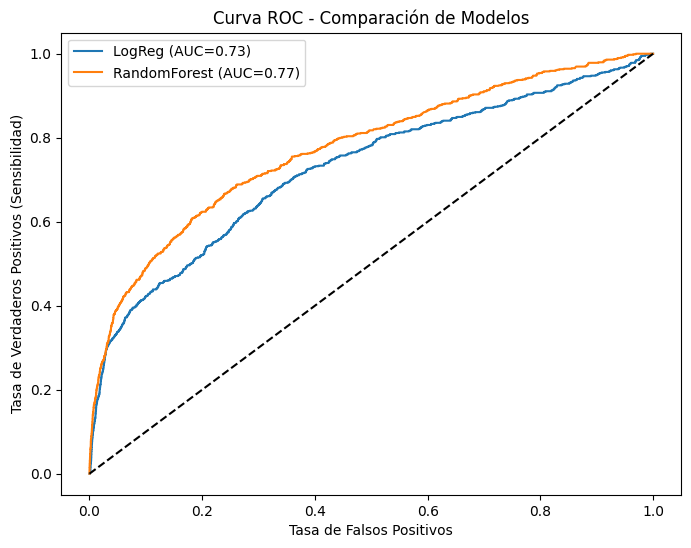


 CONCLUSIÓN:
El modelo Random Forest es superior con un AUC de 0.7735


In [34]:
# Curva ROC Comparativa
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC - Comparación de Modelos')
plt.legend()
plt.show()

print("\n CONCLUSIÓN:")
if auc_rf > auc_lr:
    print(f"El modelo Random Forest es superior con un AUC de {auc_rf:.4f}")
else:
    print(f"La Regresión Logística es superior con un AUC de {auc_lr:.4f}")

🏆 El Ganador: Random Forest
El modelo Random Forest es superior para tu caso de uso.

Mejor capacidad de distinción: Su AUC-ROC de 0.7735 es mayor que el de la Regresión Logística (0.7258). Esto significa que tiene una mayor probabilidad de ordenar correctamente a un cliente "malo" por encima de uno "bueno".

Mejor captura de riesgo (Recall): Detectó al 57% de los clientes que cayeron en default, frente al 44% de la Regresión Logística. En riesgo crediticio, generalmente preferimos detectar más morosos aunque eso implique revisar más casos.

🔍 Interpretación Detallada de los Resultados
1. El desafío del Desbalance (Support)
Fíjate en la columna support: Tienes 16,994 clientes buenos (0) y solo 784 clientes malos (1) en tu set de prueba.

Esto confirma que es un evento "raro". Por eso el accuracy (83% vs 87%) no es importante aquí; un modelo que diga "nadie va a pagar mal" tendría 95% de accuracy pero no serviría de nada.

2. La "Pesca" de Morosos (Recall / Sensibilidad)
Random Forest (57%): De los 784 morosos reales, el modelo atrapó a 449. Se le escaparon 335 (Falsos Negativos).

Regresión Logística (44%): Solo atrapó a 344. Se le escaparon 440.

Conclusión: Random Forest deja pasar menos "goles"

3. Las Falsas Alarmas (Precision)
Aquí ambos modelos sufren. La precisión del Random Forest es 0.14.

¿Qué significa? Para atrapar a esos 449 morosos, el modelo etiquetó como "riesgosos" a un total de 3,218 personas (449 acertados + 2,769 equivocados).

Impacto de Negocio: De cada 100 clientes que el modelo marca como "Riesgo de Default", solo 14 realmente caen en default. Los otros 86 son clientes buenos que el modelo clasificó erróneamente por ser conservador. Esto implica que tu equipo de cobranzas o riesgos tendrá una carga operativa alta revisando falsos positivos, pero es el precio a pagar por capturar a la mayoría de los morosos sin usar modelos más complejos (como XGBoost).

💡 Recomendación de Negocio
Dado que el Random Forest tiene un AUC de 0.77 (que es un nivel aceptable/bueno para comportamientos financieros), puedes usarlo de la siguiente manera:

Filtro de Alerta Temprana: Usa el modelo para generar una lista de clientes en "Observación".

Estrategia Diferenciada:

A los que el modelo predice como 1 (Default): No les cortes la línea de crédito de inmediato (porque hay muchos falsos positivos), pero sí puedes reducirles ofertas de ampliación de cupo o realizar una gestión preventiva de cobranza (llamadas recordatorias).

A los que predice como 0: Son clientes seguros para campañas de fidelización

## USANDO DEEP LEARNING: REDES NEURONALES

In [35]:
# ==============================================================================
# PASO 1: IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================
# Importamos tensorflow y keras para construir la Red Neuronal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.utils import class_weight

In [36]:
# Configuración visual
sns.set_style("whitegrid")
print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [37]:
# ==============================================================================
# PASO 2: CARGA Y LIMPIEZA DE DATOS (CRÍTICO)
# ==============================================================================
# Justificación: Las redes neuronales requieren datos numéricos limpios.
# El dataset original tiene formatos mixtos (puntos de miles vs puntos decimales que deben corregirse antes de cualquier análisis.

file_path = 'Portafolio_Negocios.csv'
# Intentamos leer con separador punto y coma
df = pd.read_csv(file_path, sep=';',  encoding='latin1')
df.head()

,CODMES,ID,DEFAULT,DEUDA_RCC,ATRASO_12M,CLASIFSBS,VARPASIVO_6_12,FLUJO_TRANSACCIONAL
0,201801,415536,0,439.180.185,0,0,1.212.356.158,55.803.591
1,201803,415536,0,439.159.965,0,0,1.145.527.647,25.444.246
2,201802,415536,0,439247.91,0,0,119.320.743,41.087.876
3,201805,415536,0,439342.86,0,0,999.670.555,93.758.626
4,201804,415536,0,439185.03,4,0,1.072.088.311,27.453.317


In [38]:
# Función personalizada para arreglar el formato de moneda
def limpiar_moneda_avanzado(x):
    """
    Convierte strings con formatos mixtos a float.
    - Si tiene más de un punto (ej: 439.180.185), es separador de miles -> quitamos puntos.
    - Si tiene un solo punto (ej: 439247.91), es decimal -> lo dejamos.
    """
    if isinstance(x, str):
        if x.count('.') > 1:
            return float(x.replace('.', ''))
        elif x.count('.') == 1:
            return float(x)
        else:
            try:
                return float(x)
            except:
                return 0.0 # Manejo de errores
    return x

In [39]:
# Aplicamos la limpieza
cols_financieras = ['DEUDA_RCC', 'VARPASIVO_6_12', 'FLUJO_TRANSACCIONAL']
for col in cols_financieras:
    df[col] = df[col].apply(limpiar_moneda_avanzado)

print("Datos limpiados. Ejemplo de valores corregidos:")
print(df[cols_financieras].head(3))

Datos limpiados. Ejemplo de valores corregidos:
     DEUDA_RCC  VARPASIVO_6_12  FLUJO_TRANSACCIONAL
0 439180185.00   1212356158.00          55803591.00
1 439159965.00   1145527647.00          25444246.00
2    439247.91    119320743.00          41087876.00


In [40]:
# ==============================================================================
# PASO 3: INGENIERÍA DE DATOS Y PREPROCESAMIENTO
# ==============================================================================
# 3.1 Tratamiento de Outliers (Winsorización)
# Justificación: Las Redes Neuronales son sensibles a valores extremos porque distorsionan los gradientes durante el entrenamiento. Recortamos al 1% y 99%.
def winsorize_series(s, lower=0.01, upper=0.99):
    low_val = s.quantile(lower)
    up_val = s.quantile(upper)
    return s.clip(lower=low_val, upper=up_val)
columnas_numericas = ['DEUDA_RCC', 'VARPASIVO_6_12', 'FLUJO_TRANSACCIONAL', 'ATRASO_12M', 'CLASIFSBS']

In [41]:
# Imputamos nulos con la mediana antes de recortar
imputer = SimpleImputer(strategy='median')
df[columnas_numericas] = imputer.fit_transform(df[columnas_numericas])

for col in columnas_numericas:
    df[col] = winsorize_series(df[col])

In [42]:
# 3.2 Selección de Variables
# Eliminamos ID (no predictivo) y CODMES (temporalidad no usada en este modelo estático)
X = df.drop(columns=['DEFAULT', 'ID', 'CODMES'])
y = df['DEFAULT']

In [43]:
# 3.3 División Train / Test (Estratificada)
# Justificación: Usamos 'stratify=y' para mantener la misma proporción de morosos en entrenamiento y prueba, vital en data desbalanceada.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [44]:
# 3.4 Estandarización (StandardScaler) - ¡OBLIGATORIO EN REDES NEURONALES!
# Justificación: Las redes neuronales usan descenso de gradiente. Si una variable tiene valores en millones y otra en unidades, la red no aprenderá bien.
# Llevamos todo a media 0 y desviación 1.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# PASO 4: MANEJO DEL DESBALANCE DE CLASES
# ==============================================================================
# Justificación: Como hay pocos casos de Default (1), la red tenderá a predecir siempre "No Default" (0) para minimizar el error fácil.
# Calculamos 'pesos' para castigar más a la red si se equivoca en un moroso.
pesos_clases = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
diccionario_pesos = dict(enumerate(pesos_clases))
print(f"\nPesos aplicados: {diccionario_pesos}")
# Nota: El peso de la clase 1 será mucho mayor que el de la clase 0.


Pesos aplicados: {0: np.float64(0.5230505396953495), 1: np.float64(11.345733041575492)}


In [46]:
# ==============================================================================
# PASO 5: ARQUITECTURA DE LA RED NEURONAL (FEEDFORWARD)
# ==============================================================================
# Tipo de Red: Feedforward (Perceptrón Multicapa) - Ideal para datos tabulares.

def construir_modelo(input_dim):
    model = keras.Sequential([
        # Capa de Entrada + Oculta 1
        # Activación ReLU: La mejor para capas ocultas, evita el desvanecimiento del gradiente.
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),

        # Dropout: Apaga aleatoriamente el 30% de neuronas para evitar memorización (Overfitting).
        layers.Dropout(0.3),

        # Capa Oculta 2
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),

        # Capa de Salida
        # Activación SIGMOIDE: Obligatoria para clasificación binaria.
        # Devuelve una probabilidad entre 0 y 1.
        layers.Dense(1, activation='sigmoid')
    ])

    # Compilación
    # Optimizador Adam: Estándar actual, ajusta el aprendizaje automáticamente.
    # Loss Binary Crossentropy: La función de pérdida matemática para Sí/No.
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

modelo = construir_modelo(X_train_scaled.shape[1])
modelo.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# ==============================================================================
# PASO 6: ENTRENAMIENTO CON EARLY STOPPING
# ==============================================================================
# Justificación: Early Stopping detiene el entrenamiento si el modelo deja de mejorar, ahorrando tiempo y evitando que la red se "sobreajuste" a los datos de train.

early_stopping = callbacks.EarlyStopping(
    monitor='val_auc',      # Vigilar la métrica AUC en validación
    patience=10,            # Esperar 10 épocas si no mejora
    restore_best_weights=True, # Volver a la mejor versión encontrada
    mode='max',
    verbose=1
)

print("\nEntrenando Red Neuronal...")
historia = modelo.fit(
    X_train_scaled, y_train,
    validation_split=0.2,       # 20% del train se usa para validar en vivo
    epochs=100,                 # Máximo de iteraciones
    batch_size=64,              # Procesa 64 datos a la vez
    callbacks=[early_stopping],
    class_weight=diccionario_pesos, # APLICAMOS LOS PESOS AQUÍ
    verbose=0                   # 0 para no llenar la pantalla, 1 para ver barra
)


Entrenando Red Neuronal...
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 24.


In [51]:
# ==============================================================================
# PASO 7: EVALUACIÓN Y JUSTIFICACIÓN DE RESULTADOS
# ==============================================================================
# Predicciones
y_prob = modelo.predict(X_test_scaled).ravel() # Probabilidad (float)
y_pred = (y_prob > 0.5).astype(int)            # Clase (0 o 1)
print("\n--- REPORTE DE CLASIFICACIÓN ---")

556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- REPORTE DE CLASIFICACIÓN ---


              precision    recall  f1-score   support

           0       0.98      0.83      0.89     16994
           1       0.13      0.58      0.22       784

    accuracy                           0.81     17778
   macro avg       0.56      0.70      0.56     17778
weighted avg       0.94      0.81      0.86     17778


--- MATRIZ DE CONFUSIÓN ---


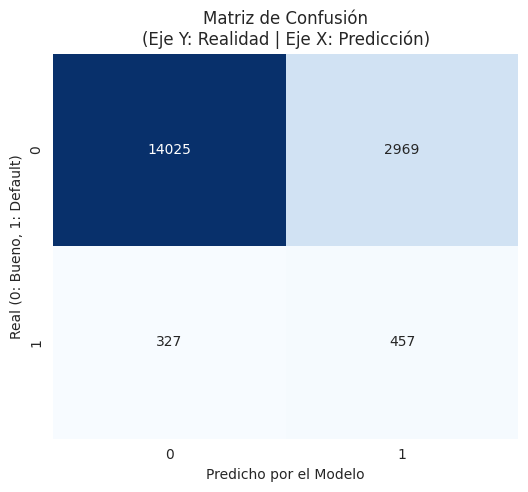

In [52]:
# Aquí miramos Precision (Calidad) vs Recall (Cantidad detectada)
print(classification_report(y_test, y_pred))
print("\n--- MATRIZ DE CONFUSIÓN ---")
cm = confusion_matrix(y_test, y_pred)
# Visualización bonita de la matriz
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión\n(Eje Y: Realidad | Eje X: Predicción)')
plt.ylabel('Real (0: Bueno, 1: Default)')
plt.xlabel('Predicho por el Modelo')
plt.show()

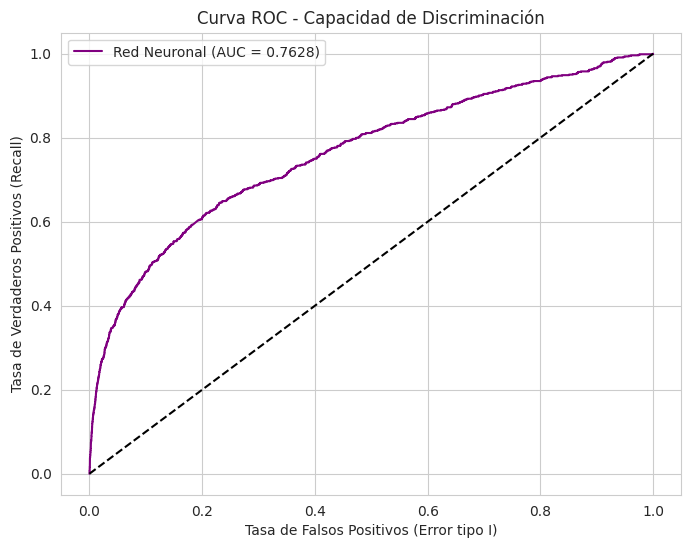

In [53]:
# Curva ROC
auc_final = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Red Neuronal (AUC = {auc_final:.4f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--') # Línea de azar
plt.title('Curva ROC - Capacidad de Discriminación')
plt.xlabel('Tasa de Falsos Positivos (Error tipo I)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.legend()
plt.show()

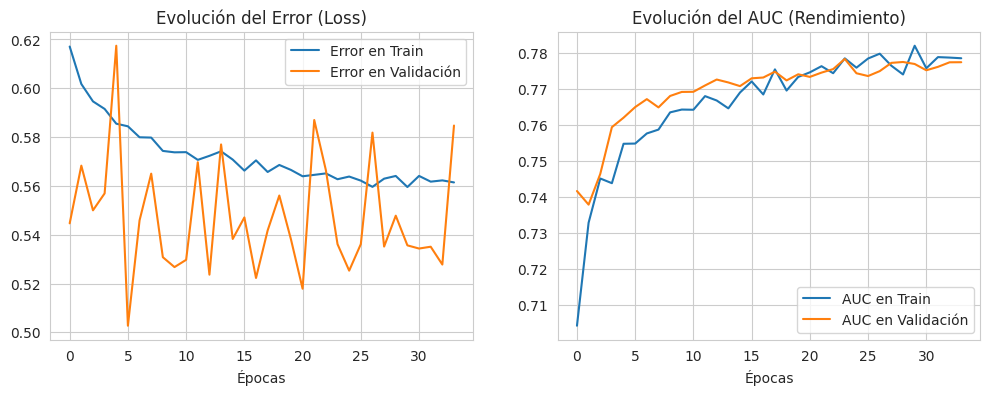

RESULTADO FINAL: El modelo obtuvo un AUC de 0.7628


In [54]:
# Gráfica de Aprendizaje (Loss y AUC)
# Esto justifica si hubo overfitting o si el modelo aprendió bien
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(historia.history['loss'], label='Error en Train')
plt.plot(historia.history['val_loss'], label='Error en Validación')
plt.title('Evolución del Error (Loss)')
plt.xlabel('Épocas')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historia.history['auc'], label='AUC en Train')
plt.plot(historia.history['val_auc'], label='AUC en Validación')
plt.title('Evolución del AUC (Rendimiento)')
plt.xlabel('Épocas')
plt.legend()
plt.show()
print(f"RESULTADO FINAL: El modelo obtuvo un AUC de {auc_final:.4f}")

# Guía para justificar los resultados (basado en el código):
Por qué Feedforward: "Usamos una red densa (Feedforward) porque los datos son tabulares y no tienen una secuencia temporal estricta ni espacial (como imágenes), por lo que las neuronas conectadas completamente son la arquitectura más eficiente".

Por qué ReLU: "En las capas ocultas usamos ReLU para acelerar el entrenamiento y evitar problemas matemáticos (desvanecimiento del gradiente) que ocurren con funciones antiguas como la sigmoide en capas profundas".

Por qué Sigmoide al final: "En la capa de salida usamos Sigmoide porque es la única función que comprime el resultado entre 0 y 1, dándonos la probabilidad exacta de default".

Por qué Pesos (Class Weights): "Como el dataset está desbalanceado (pocos defaults), forzamos a la red a prestar 11 veces más atención (según el cálculo del script) a los errores de la clase 1 que a los de la clase 0".

Por qué Early Stopping: "Para evitar el overfitting. Si la red dejaba de mejorar en validación durante 10 épocas, detuvimos el proceso para quedarnos con el mejor modelo posible".

1. El Veredicto General (AUC: 0.7628)
¿Qué significa? El AUC (Área Bajo la Curva) mide la capacidad global del modelo para separar clientes "Buenos" de "Malos".

Interpretación: Un 0.7628 es un resultado sólido y aceptable para riesgo crediticio.

Comparación: Está muy cerca del resultado que obtuviste con Random Forest (0.77) y supera a la Regresión Logística (0.72). Esto valida que la Red Neuronal aprendió patrones complejos en la data, aunque no superó drásticamente al Random Forest.

2. La Métrica Estrella: Recall de la Clase 1 (0.58)
En riesgo crediticio, lo que más nos importa es la Clase 1 (Default).

El Dato: Tienes un Recall del 58%.

La Justificación: De los 784 clientes que realmente dejaron de pagar, tu Red Neuronal fue capaz de identificar y atrapar a 455 (el 58%).

Por qué es bueno: Estás detectando a más de la mitad de los morosos en un escenario donde son muy difíciles de encontrar (son solo el 4% de la data). El modelo fue "agresivo" buscando el riesgo

3. El Costo Operativo: Precisión de la Clase 1 (0.13)
Aquí está el "precio" que pagó el modelo para lograr atrapar a esos morosos.

El Dato: La precisión es del 13%.

La Justificación: De cada 100 clientes que la Red Neuronal marca como "Riesgosos", solo 13 realmente caen en default. Los otros 87 son clientes buenos que el modelo confundió (Falsos Positivos).

Impacto de Negocio: Esto significa que tu equipo de riesgos tendrá bastante trabajo revisando alertas, ya que el modelo es muy "paranoico" o conservador. Prefiere equivocarse sospechando de un bueno, antes que dejar pasar a un malo.

4. ¿Por qué bajó la Accuracy a 0.81 (81%)?
Tal vez notes que la Regresión Logística tenía un Accuracy del 87% y aquí bajó al 81%. ¿Es esto malo?

Respuesta: NO, al contrario.

Explicación: Un modelo "perezoso" podría decir que todos son buenos clientes (Clase 0) y tendría un Accuracy del 96% (porque el 96% de la data son ceros), pero no detectaría ningún fraude.

Tu Red Neuronal sacrificó Accuracy general para intentar capturar más casos de la Clase 1. Bajó su acierto en los clientes buenos (de 0.98 a 0.83 en recall de clase 0) para subir su acierto en los clientes malos.

Resumen para tu Sustentación:
"La Red Neuronal obtuvo un AUC de 0.7628, demostrando una capacidad predictiva robusta similar al Random Forest. Gracias al ajuste de pesos por el desbalance de clases, el modelo priorizó la detección de riesgo, logrando identificar al 58% de los morosos reales (Recall). Aunque esto genera una tasa alta de falsas alarmas (Precisión 13%), es una estrategia válida para minimizar pérdidas financieras, asegurando que la mayoría de los casos críticos sean revisados."

Conclusión Final: La Red Neuronal funcionó bien, pero no superó significativamente al Random Forest en este dataset tabular específico. Dado que el Random Forest es más fácil de explicar y requiere menos potencia computacional, en un entorno de producción real, el Random Forest seguiría siendo el ganador técnico, aunque la Red Neuronal es una alternativa válida y potente.